# Valuable Institutions: What Makes a University a Better Investment?

Introduction

## Data Curation and Management

This part of the tutorial will focus on the first 2 components of "The Data Science Pipeline": data collection / curation and data management / representation.

The data being analyzed is the US Department of Education's College Scorecard, available here: https://collegescorecard.ed.gov/data/  
The College Scorecard includes aggregrate data for thousands of postsecondary education institutions regarding institutional characteristics, enrollment, student aid, costs, and student outcomes.

This tutorial seeks to use this dataset to explore how institutional characteristics influence the value attained by students. A measurement of value would incorporate a metric defined by student outcomes in comparison to net student costs (student costs - aid).

Before we can begin, it's important to define some key attributes (or variables) that we will use to (1) limit the scope of the analysis, (2) distinguish the characteristics of each institution, (3) provide a metric of value associated with the university, and (4) demonstrate demographic representations for insights regarding equity.

**Limiting Attributes (filtering variables)**:
- Highest degree awarded (`HIGHDEG = 4`) - Institution should offer a graduate degree. These institutions have the most resources available to them and are more fair to compare to each other.
- Currently operational (`CURROPER = 1`) - Institution should still be operational. We are not performing a historical analysis, so insights are most relevant about institutions that are still serving the population.
- Level of Institution (`ICLEVEL = 1`) - Institution should be a 4-year institution. This ensures that the institutions included in the analysis are comparable in terms of objective and mission.

**Institutional characteristics of interest (independent variables)**:
- Locale type (City | Suburb | Town | Rural) (`LOCALE`)
- Control (Public | Private Nonprofit | Private For-Profit) (`CONTROL`)
- Admission Rate (`ADM_RATE`)
- Enrollment (`UGDS`)

**Value Metrics (dependent variables)**:
- Average Net Price (`NPT4_PUB` or `NPT4_PRIV`) - Important note: at public institutions, this is the student cost for *in-state* students only. This does not interfere with the analysis because all students have the choice to attend an in-state public university. A measurement of value should be based off of the lower cost of attendance seen by most students.
    - for $0 - $30,000 family income (`NPT41_PUB` or `NPT41_PRIV`)
    - for $30,001 - $48,000 family income (`NPT42_PUB` or `NPT42_PRIV`)
    - for $48,001 - $75,000 family income (`NPT43_PUB` or `NPT43_PRIV`)
    - for $75,001 - $110,000 family income (`NPT44_PUB` or `NPT44_PRIV`)
    - for $110,000+ family income (`NPT45_PUB` or `NPT45_PRIV`)
- Median Earnings of students working and not enrolled after 10 years (from enrollment) (`MD_EARN_WNE_P10`) - Important note: this statistic includes the earnings of students who did not complete their education, but the statistic is unlikely to be affected because it is a median.

For our purposes, we will define investment-earnings equivalent (IEE) as the break-even point between cost of attendance and earnings. In other words, this is the ratio between 4 years of the average net annual price (ANP) and median earnings at 10 years after enrollment (ME). As a mathematical formula: $$IEE = \frac{4*ANP}{ME}$$

This is a relativistic metric that is most useful in providing a standardized comparison of institutions to each other. In essence, it describes the number of years it takes for the student to recoup the cost of attending that institution or in other terms, the return on investment. In future analyses and comparisons, it should be noted that a *lower* IEE indicates that an institution is a more valuable investment than a higher IEE institution. This metric does **not** account for living expenses and tax costs, and therefore should not be confused with the student's debt repayment period. For example if an institutions's ANP is $30,000, and the ME is $55,000, then $IEE = \frac{4*30,000}{55,000} = 2.18$. That being the educational investment required to attend the institution is equivalent to *2.18 years of work earnings* after enrollment.

In [1]:
import pandas as pd

In [2]:
# Import institution-level data for postsecondary education
inst_level = pd.read_csv('data/Most-Recent-Cohorts-Institution.csv', low_memory=False)
# print(inst_level['INSTNM'].count())

Now that we have the data in a workable format, it's time to begin our preliminary manipulations by applying the limiting attributes detailed above.

In [3]:
# Filter entries to currently operational institutions
inst_level = inst_level.loc[inst_level['CURROPER'] == 1]

# Filter entries to graduate-degree offering institutions
inst_level = inst_level.loc[inst_level['HIGHDEG'] == 4]

# Filter entries to 4-year institutions
inst_level = inst_level.loc[inst_level['ICLEVEL'] == 1]

**Calculating IEE for all institutions**:  
Before we continue on to exploring our data, we should calculate the IEE for all institutions. We will be using these values often in the coming analyses, so it would be much more efficient to calculate them a single time now and use the pre-calculated values in the future.

In [4]:
# Permanently drop any institution that doesn't have average net price or median earnings data.
inst_level = inst_level.dropna(subset='MD_EARN_WNE_P10')
inst_level = inst_level.dropna(subset=['NPT4_PUB', 'NPT4_PRIV'], thresh=1)

# Add an empty IEE column to the dataset
inst_level['IEE'] = 0.0

# Calculate IEE for each institution and add it to the data entry.
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        inst_level.at[inst[0], 'IEE'] = float(4*inst[1]['NPT4_PUB'] / inst[1]['MD_EARN_WNE_P10'])
    else:
        inst_level.at[inst[0], 'IEE'] = float(4*inst[1]['NPT4_PRIV'] / inst[1]['MD_EARN_WNE_P10'])

## Exploratory Data Analysis

In [5]:
import matplotlib.pyplot as plt

Let's start by exploring relationships between our independent variables and our IEE value metric:
- IEE vs. Locale
- IEE vs. Control
- IEE vs. Admission Rate
- IEE vs. Enrollment

### IEE vs. Institution Locale

We'll plot the average net price of attendance at each university as a function of the institution's locale. The locale can be either city, suburb, town, or rural. An appropriate plot to visualize this relationship would be a violin plot that can show centrality, minimums, maximums, and distribution for each locale on the same plot.

In [6]:
# Aggregate data for each locale
inst_locales = [[],[],[],[]] # array with an array for each locale
for inst in inst_level.iterrows():
    # City locale
    if inst[1]['LOCALE'] >= 11 and inst[1]['LOCALE'] <= 13:
        inst_locales[0].append(inst[1]['IEE'])

    # Suburb locale
    elif inst[1]['LOCALE'] >= 21 and inst[1]['LOCALE'] <= 23:
        inst_locales[1].append(inst[1]['IEE'])

    # Town locale
    elif inst[1]['LOCALE'] >= 31 and inst[1]['LOCALE'] <= 33:
        inst_locales[2].append(inst[1]['IEE'])

    # Rural locale
    else: # inst[1]['LOCALE'] >= 41 and inst[1]['LOCALE'] <= 43
        inst_locales[3].append(inst[1]['IEE'])

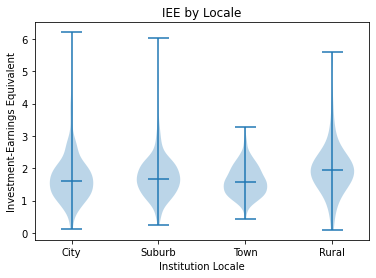

In [7]:
# Set up plot
plt.figure()
plt.title('IEE by Locale')
plt.xlabel('Institution Locale')
plt.ylabel('Investment-Earnings Equivalent')

# Set up locale labels
locales = ['City', 'Suburb', 'Town', 'Rural']
locales_pos = range(1,5)
plt.xticks(locales_pos, locales)

plt.violinplot(inst_locales, locales_pos, showmedians=True)
print()

This plot shows that the IEE for each locale is pretty similar. All locales have IEEs centered between 1.5 and 2. Cities and suburbs have high outlier institutions. All 4 locales have mostly symmetric unimodal distributions that slightly skew upwards. The distribution of rural institutions is a bit wider than the rest, but it also has the lowest sample size. Shown below are the number of institutions in each locale. The association between IEE and locale is not worth further investigation. 

In [8]:
# Number of institutions per locale
print('City institutions: ' + str(len(inst_locales[0])))
print('Suburb institutions: ' + str(len(inst_locales[1])))
print('Town institutions: ' + str(len(inst_locales[2])))
print('Rural institutions: ' + str(len(inst_locales[3])))

City institutions: 758
Suburb institutions: 362
Town institutions: 272
Rural institutions: 74


### IEE by Institution Control

In [9]:
# Aggregate data for each control type
inst_controls = [[],[],[]] # array with an array for each locale
for inst in inst_level.iterrows():
    # Public control
    if inst[1]['CONTROL'] == 1:
        inst_controls[0].append(inst[1]['IEE'])

    # Private Nonprofit control
    elif inst[1]['CONTROL'] == 2:
        inst_controls[1].append(inst[1]['IEE'])

    # Private For-profit control
    else: # inst[1]['CONTROL'] == 3
        inst_controls[2].append(inst[1]['IEE'])

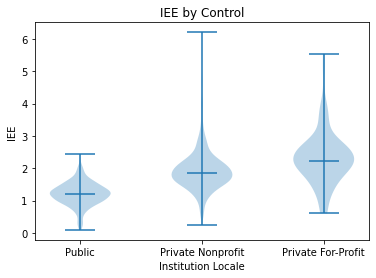

In [10]:
# Set up plot
plt.figure()
plt.title('IEE by Control')
plt.xlabel('Institution Locale')
plt.ylabel('IEE')

# Set up control labels
controls = ['Public','Private Nonprofit', 'Private For-Profit']
controls_pos = range(1,4)
plt.xticks(controls_pos, controls)

plt.violinplot(inst_controls, controls_pos, showmedians=True)
print()

The plot shows a clear divide between the IEEs of public and private institutions. All 3 control types have mostly symmetric unimodal distributions, but private institutions do have upward skews. The two different types of private institutions have similar enough distributions that we can homogenize them into one category. The association between IEE and institution control type is worth further investigation.

In [11]:
# Number of institutions per control
print('Public institutions: ' + str(len(inst_controls[0])))
print('Private Nonprofit institutions: ' + str(len(inst_controls[1])))
print('Private For-Profit institutions: ' + str(len(inst_controls[2])))

Public institutions: 510
Private Nonprofit institutions: 857
Private For-Profit institutions: 99


### IEE vs. Institution Admission Rate

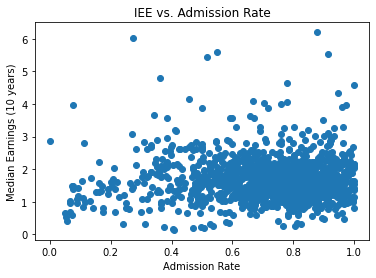

In [12]:
# Set up plot
plt.figure()
plt.title('IEE vs. Admission Rate')
plt.xlabel('Admission Rate')
plt.ylabel('Median Earnings (10 years)')

plt.scatter(inst_level['ADM_RATE'], inst_level['IEE'])

This plot is extremely valuable as a starting point. It demonstrates two key concepts: (1) most institutions have higher admission rates (>50%) and (2) institions with lower admission rates tend to have higher median earnings afterwards. This makes sense as institutions that are more selective have more skilled and valuable applicants, and they receive more attention from high-paying companies for recruitment. Admission rate is definitely a good institutional characteristic to investigate.

### IEE vs. Enrollment

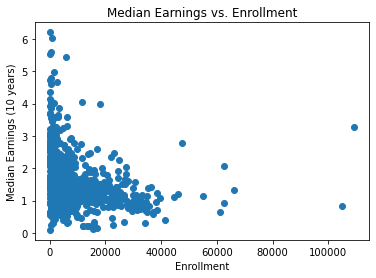

In [13]:
# Set up plot
plt.figure()
plt.title('Median Earnings vs. Enrollment')
plt.xlabel('Enrollment')
plt.ylabel('Median Earnings (10 years)')

plt.scatter(inst_level['UGDS'], inst_level['IEE'])

This plot offers some interesting information. The distribution is unimodal with a distinct upwards skew. It seems that higher enrollment institutions tend to have lower IEEs than lower enrollment institutions. A limitation of this visualization is that we have notion of density at any part of the plot. There is likely many more institutions with low enrollment than high enrollment. Enrollment figures are probably not worth further investigation

## Hypothesis Testing

**Insights from Data Exploration**:  
After exploring the data that we have, we've come to the conclusion that the independent variables of interest to our analysis are the control type of the institution and the institution's admission rate. This makes sense logically, as both control type and admission rate are forms of selection or filtration of the enrollment class.

Control type is directly associated with the socio-economic standing of the applicants. Private institutions tend to be much more expensive and have limited financial aid options compared to public universities. Therefore applicants from more wealthy backgrounds are more likely to be able to afford going to private institutions.

Admission rate is a reflection of how selective an institution's admissions process when it comes to a heuristic analysis of an applicant's accomplishments. A lower admission rate typically means that a university is in higher demand due to the quality of its education and/or connections. 

**Hypothesis**:  
From our preliminary data analysis, we know that earnings are higher for universities with lower admissions rates and that costs are higher for private institutions. Based on these facts, we will hypothesize that the IEE will be lower for institutions with lower admissions rates and higher for private institutions.  

### Visualizing Hypothesis Variables

Before we can begin fitting statistical models, we need to aggregate the data we've chosen to analyze and decide if any adjustments are needed. The best way to determine if adjustments are needed, and subsequently what adjustments to make, is to visualize the data of interest.

In [14]:
import statistics as stat
import numpy as np

In [15]:
# Permanently drop any institution that does not have admissions data
inst_level = inst_level.dropna(subset='ADM_RATE')

# Permanently homogenize public nonprofit and for-profit institutions
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 3:
        inst_level.at[inst[0], 'CONTROL'] = 2

# Collect the IEE and admission rates of public and private institutions in 2 different pairs of parallel arrays.
public_IEE = []
public_ADM = []
private_IEE = []
private_ADM = []
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        public_IEE.append(inst[1]['IEE'])
        public_ADM.append(inst[1]['ADM_RATE'])
    else:
        private_IEE.append(inst[1]['IEE'])
        private_ADM.append(inst[1]['ADM_RATE'])

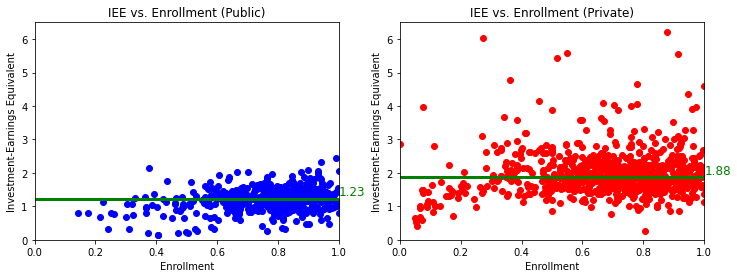

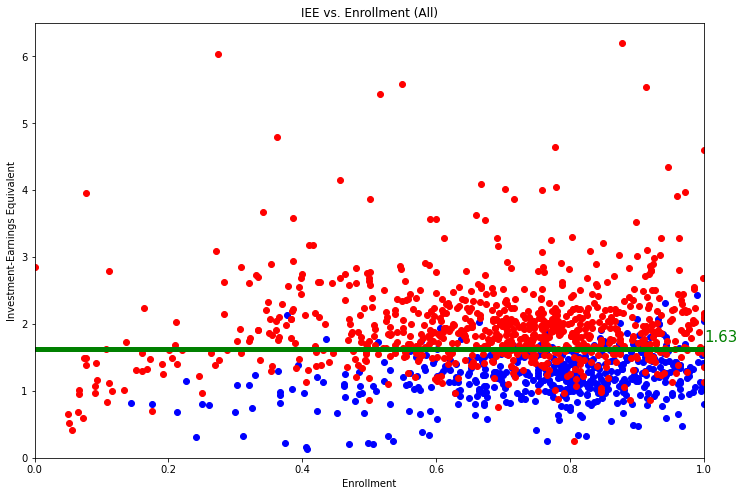

In [16]:
plt.figure(figsize=(12,4))

# Set up public institution plot
ax1 = plt.subplot(1,2,1)
ax1.scatter(public_ADM, public_IEE, color='blue')
ax1.axhline(stat.median(public_IEE), color='green', linewidth=3)
ax1.text(1, stat.median(public_IEE) + 0.1, str(round(stat.median(public_IEE), 2)), color='green', size=12)
ax1.set_title('IEE vs. Enrollment (Public)')
ax1.set_xlabel('Enrollment')
ax1.set_ylabel('Investment-Earnings Equivalent')
ax1.set_ylim([0, 6.5])
ax1.set_xlim([0, 1])

# Set up private institution plot
ax2 = plt.subplot(1,2,2)
ax2.scatter(private_ADM, private_IEE, color='red')
ax2.axhline(stat.median(private_IEE), color='green', linewidth=3)
ax2.text(1, stat.median(private_IEE) + 0.1, str(round(stat.median(private_IEE), 2)), color='green', size=12)
ax2.set_title('IEE vs. Enrollment (Private)')
ax2.set_xlabel('Enrollment')
ax2.set_ylabel('Investment-Earnings Equivalent')
ax2.set_ylim([0, 6.5])
ax2.set_xlim([0, 1])

# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Enrollment (All)')
plt.xlabel('Enrollment')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 6.5])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')
plt.axhline(stat.median(public_IEE + private_IEE), color='green', linewidth=5)
plt.text(1, stat.median(public_IEE + private_IEE) + 0.1, str(round(stat.median(public_IEE + private_IEE), 2)), color='green', size=15)
print()

Each plot has a green horizontal line at the median IEE for that group (public, private, all respectively). The median IEE for public schools is drastically lower than the median IEE for private schools.

These set of plots indicate something about our hypothesis that will need to verified statistically: institution control type is a better a predictor of value than enrollment. Institional value (in terms of IEE) is generally better at higher enrollment populations and it's also clear that public institutions offer greater value than private institutions.

In [17]:
Q3 = np.quantile(inst_level['IEE'], 0.75)
Q1 = np.quantile(inst_level['IEE'], 0.25)
IQR = Q3 - Q1

print(inst_level['IEE'].count())
inst_level = inst_level.loc[inst_level['IEE'] < (Q3 + IQR)]
inst_level = inst_level.loc[inst_level['IEE'] > (Q1 - IQR)]
print(inst_level['IEE'].count())
print('Non-outlier Range: (' + str(Q1 - IQR) + ' , ' + str(Q3 + IQR) + ')')

1291
1194
Non-outlier Range: (0.5291975636680775 , 2.737789537564892)


In [18]:
# Recollect the IEE and admission rates without the outliers.
public_IEE = []
public_ADM = []
private_IEE = []
private_ADM = []
for inst in inst_level.iterrows():
    if inst[1]['CONTROL'] == 1:
        public_IEE.append(inst[1]['IEE'])
        public_ADM.append(inst[1]['ADM_RATE'])
    else:
        private_IEE.append(inst[1]['IEE'])
        private_ADM.append(inst[1]['ADM_RATE'])

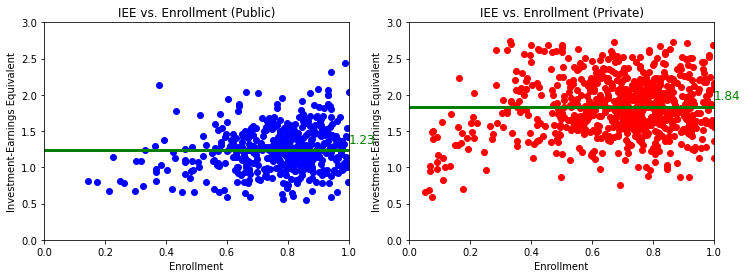

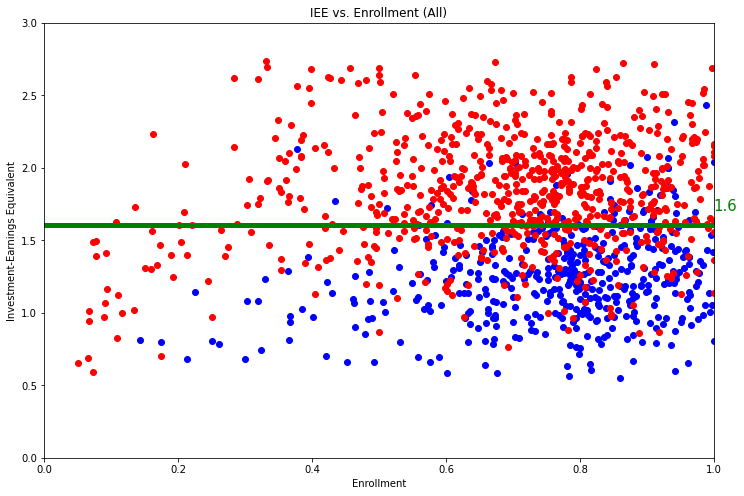

In [19]:
plt.figure(figsize=(12,4))

# Set up public institution plot
ax1 = plt.subplot(1,2,1)
ax1.scatter(public_ADM, public_IEE, color='blue')
ax1.axhline(stat.median(public_IEE), color='green', linewidth=3)
ax1.text(1, stat.median(public_IEE) + 0.1, str(round(stat.median(public_IEE), 2)), color='green', size=12)
ax1.set_title('IEE vs. Enrollment (Public)')
ax1.set_xlabel('Enrollment')
ax1.set_ylabel('Investment-Earnings Equivalent')
ax1.set_ylim([0, 3])
ax1.set_xlim([0, 1])

# Set up private institution plot
ax2 = plt.subplot(1,2,2)
ax2.scatter(private_ADM, private_IEE, color='red')
ax2.axhline(stat.median(private_IEE), color='green', linewidth=3)
ax2.text(1, stat.median(private_IEE) + 0.1, str(round(stat.median(private_IEE), 2)), color='green', size=12)
ax2.set_title('IEE vs. Enrollment (Private)')
ax2.set_xlabel('Enrollment')
ax2.set_ylabel('Investment-Earnings Equivalent')
ax2.set_ylim([0, 3])
ax2.set_xlim([0, 1])

# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Enrollment (All)')
plt.xlabel('Enrollment')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')
plt.axhline(stat.median(public_IEE + private_IEE), color='green', linewidth=5)
plt.text(1, stat.median(public_IEE + private_IEE) + 0.1, str(round(stat.median(public_IEE + private_IEE), 2)), color='green', size=15)
print()

### Statistical Modeling & Hypothesis Testing

For this data, we need to produce some sort of regressor because we are predicting a numeric value. Let's start with the simplest regressor - a linear regression model. 

In [20]:
Q3 = np.quantile(inst_level['IEE'], 0.75)
Q1 = np.quantile(inst_level['IEE'], 0.25)
IQR = Q3 - Q1

print(inst_level['IEE'].count())
inst_level = inst_level.loc[inst_level['IEE'] < (Q3 + IQR)]
inst_level = inst_level.loc[inst_level['IEE'] > (Q1 - IQR)]
print(inst_level['IEE'].count())

1194
1176


#### Simple Linear Regression

In [21]:
import statsmodels.api as sm

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [22]:
lm_est = sm.OLS(inst_level['IEE'], sm.add_constant(inst_level['ADM_RATE'])).fit()
print(lm_est.summary())

                            OLS Regression Results                            
Dep. Variable:                    IEE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.731
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.189
Time:                        18:30:49   Log-Likelihood:                -720.80
No. Observations:                1176   AIC:                             1446.
Df Residuals:                    1174   BIC:                             1456.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5346      0.050     30.394      0.0

#### Linear Regression with Interaction Term

Our hypothesis implies a statistical interaction between enrollment and institutional control type.

A statistical interaction is a relationship between variables such that 2 or more explanatory (independent) variables influence the outcome of a response (dependent) variable. In this case, both enrollment and control type can influence the IEE of that institution.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [24]:
# Reformat data for use in an interaction model.
IEEs = []
ADM_controls = []

for (iee, adm) in zip(public_IEE, public_ADM):
    IEEs.append(iee) 
    ADM_controls.append([adm, 0]) # 0 represents public school

for (iee, adm) in zip(private_IEE, private_ADM):
    IEEs.append(iee) 
    ADM_controls.append([adm, 1]) # 1 represents private school

In [30]:
# Fit interaction model using statsmodels. 
lm_int_est = sm.OLS(IEEs, sm.add_constant(ADM_controls)).fit()
print(lm_int_est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     392.1
Date:                Sun, 15 May 2022   Prob (F-statistic):          1.51e-131
Time:                        18:32:35   Log-Likelihood:                -471.74
No. Observations:                1194   AIC:                             949.5
Df Residuals:                    1191   BIC:                             964.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9879      0.045     21.776      0.0

In [26]:
poly = PolynomialFeatures(degree=3)
xp = poly.fit_transform(np.array(public_ADM + private_ADM).reshape(-1, 1))
pm_est = sm.OLS(IEEs, xp).fit()
print(pm_est.pvalues)
print(pm_est.summary())

[6.40690878e-05 1.37139458e-09 5.07040128e-08 1.01717440e-06]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     14.61
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.37e-09
Time:                        18:30:49   Log-Likelihood:                -752.12
No. Observations:                1194   AIC:                             1512.
Df Residuals:                    1190   BIC:                             1533.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [27]:
poly = PolynomialFeatures(degree=3)
xp = poly.fit_transform(ADM_controls)
pm_est = sm.OLS(IEEs, xp).fit()
print(pm_est.pvalues)
print(pm_est.summary())


[4.21428173e-01 1.04007965e-08 1.32837279e-04 6.66250179e-09
 6.27608079e-01 1.32837279e-04 7.84082316e-09 9.29725533e-01
 6.27608079e-01 1.32837279e-04]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     151.7
Date:                Sun, 15 May 2022   Prob (F-statistic):          6.57e-143
Time:                        18:30:50   Log-Likelihood:                -433.92
No. Observations:                1194   AIC:                             881.8
Df Residuals:                    1187   BIC:                             917.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

0.00032111172589011083
[0.34198219 0.61148723]
0.39699721336259985
0.03553476719908699


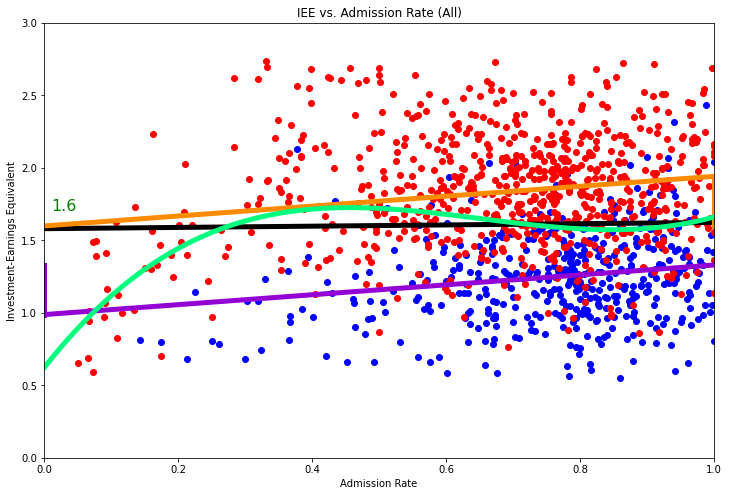

In [28]:
# Set up all institution plot
plt.figure(figsize=(12,8))
plt.title('IEE vs. Admission Rate (All)')
plt.xlabel('Admission Rate')
plt.ylabel('Investment-Earnings Equivalent')
plt.ylim([0, 3])
plt.xlim([0, 1])
plt.scatter(public_ADM, public_IEE, color='blue')
plt.scatter(private_ADM, private_IEE, color='red')
#plt.axhline(stat.median(public_IEE + private_IEE), color='green', linewidth=5)
plt.text(0.01, stat.median(IEEs) + 0.1, str(round(stat.median(IEEs), 2)), color='green', size=16)

# Fit linear regression for overall data
lm = LinearRegression().fit(np.array(public_ADM + private_ADM).reshape(-1,1), np.array(IEEs).reshape(-1,1))
print(lm.score(np.array(public_ADM + private_ADM).reshape(-1,1), np.array(IEEs).reshape(-1,1)))
plt.plot(np.linspace(0,1,100), lm.predict(np.linspace(0,1,100).reshape(-1,1)), color='black', linewidth=5)

# Fit linear regression lines for each control type
lm = LinearRegression()
lm.fit(ADM_controls, IEEs)
print(lm.coef_)
print(lm.score(ADM_controls, IEEs))
Xs_pub = []
Xs_priv = []
for x in np.linspace(0, 1, 100):
    Xs_pub.append([x, 0])
    Xs_priv.append([x, 1])
plt.plot(Xs_pub, lm.predict(Xs_pub), color='darkviolet', linewidth=5)
plt.plot(Xs_priv, lm.predict(Xs_priv), color='darkorange', linewidth=5)

# Fit polynomial regression lines for all institutions together
polyfit = np.polyfit(public_ADM + private_ADM, IEEs, 3, full=True)
SSE = polyfit[1][0]
square_diff = (np.array(IEEs) - np.array(IEEs).mean()) ** 2
SST = square_diff.sum()
r2 = 1 - SSE/SST
print(r2)
pm = np.poly1d(polyfit[0])
# print(pm)
polyline = np.linspace(0, 1, 100)
plt.plot(polyline, pm(polyline), linewidth=5, color = 'springgreen')

In [53]:
'{:05}'.format(1)

TypeError: 'int' object is not subscriptable

## Insight Analysis